In [20]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

In [21]:
customers = pd.read_csv('/content/Customers.csv')
products = pd.read_csv('/content/Products.csv')
transactions = pd.read_csv('/content/Transactions.csv')

In [22]:
# Merge datasets
merged_data = transactions.merge(customers, on="CustomerID").merge(products, on="ProductID")

# Inspect the merged data
print("Merged Dataset:\n", merged_data.head())

Merged Dataset:
   TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue  Price_x     CustomerName         Region  SignupDate  \
0      300.68   300.68   Andrea Jenkins         Europe  2022-12-03   
1      300.68   300.68  Brittany Harvey           Asia  2024-09-04   
2      300.68   300.68  Kathryn Stevens         Europe  2024-04-04   
3      601.36   300.68  Travis Campbell  South America  2024-04-11   
4      902.04   300.68    Timothy Perez         Europe  2022-03-15   

                       ProductName     Category  Price_y  
0  ComfortLiving Bluetooth Speaker  Electronics   300.68  
1  ComfortLiving 

In [23]:
# Aggregate transaction data
customer_transactions = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',        # Total spending
    'Quantity': 'sum',          # Total quantity purchased
    'ProductID': 'count'        # Total number of transactions
}).rename(columns={
    'TotalValue': 'TotalSpending',
    'Quantity': 'TotalQuantity',
    'ProductID': 'TransactionCount'
}).reset_index()

# Merge with customer demographic data
lookalike_data = pd.merge(customers, customer_transactions, on='CustomerID', how='left')

# Fill missing values
lookalike_data.fillna(0, inplace=True)

# Encode categorical variables
lookalike_data = pd.get_dummies(lookalike_data, columns=['Region'], drop_first=True)

# Standardize numerical features
scaler = StandardScaler()
numerical_features = ['TotalSpending', 'TotalQuantity', 'TransactionCount']
lookalike_data[numerical_features] = scaler.fit_transform(lookalike_data[numerical_features])


In [24]:
# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(lookalike_data.drop(['CustomerID', 'CustomerName', 'SignupDate'], axis=1))

# Convert to DataFrame for better interpretation
similarity_df = pd.DataFrame(similarity_matrix, index=lookalike_data['CustomerID'], columns=lookalike_data['CustomerID'])


In [25]:
# Create recommendations
lookalike_results = {}

for customer_id in lookalike_data['CustomerID']:
    similar_customers = similarity_df[customer_id].sort_values(ascending=False)[1:4]  # Exclude self
    lookalike_results[customer_id] = list(similar_customers.index) + list(similar_customers.values)

# Format as DataFrame
lookalike_output = pd.DataFrame({
    "CustomerID": lookalike_results.keys(),
    "SimilarCustomers": [v[:3] for v in lookalike_results.values()],
    "Scores": [v[3:] for v in lookalike_results.values()]
})


In [26]:
# Save to CSV
lookalike_output.to_csv('FirstName_LastName_Lookalike.csv', index=False)

In [27]:
# ------------------------ TASK 3--------------------------

In [28]:
# Select only numerical columns for clustering
clustering_features = lookalike_data.drop(['CustomerID', 'CustomerName', 'SignupDate'], axis=1)


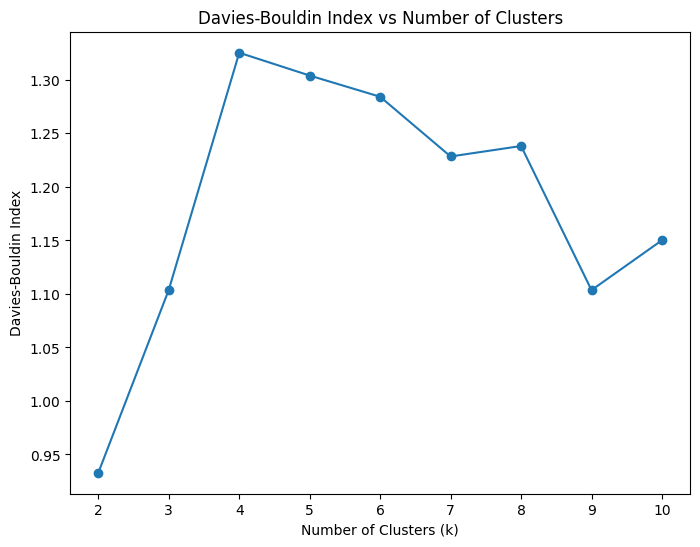

In [29]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

# Try different numbers of clusters
dbi_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(clustering_features)
    dbi = davies_bouldin_score(clustering_features, clusters)
    dbi_scores.append(dbi)

# Plot DBI scores
plt.figure(figsize=(8, 6))
plt.plot(k_values, dbi_scores, marker='o')
plt.title("Davies-Bouldin Index vs Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Davies-Bouldin Index")
plt.show()


In [30]:
# Optimal number of clusters (replace with actual value from the plot)
optimal_k = k_values[np.argmin(dbi_scores)]

# Final KMeans clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
lookalike_data['Cluster'] = kmeans.fit_predict(clustering_features)


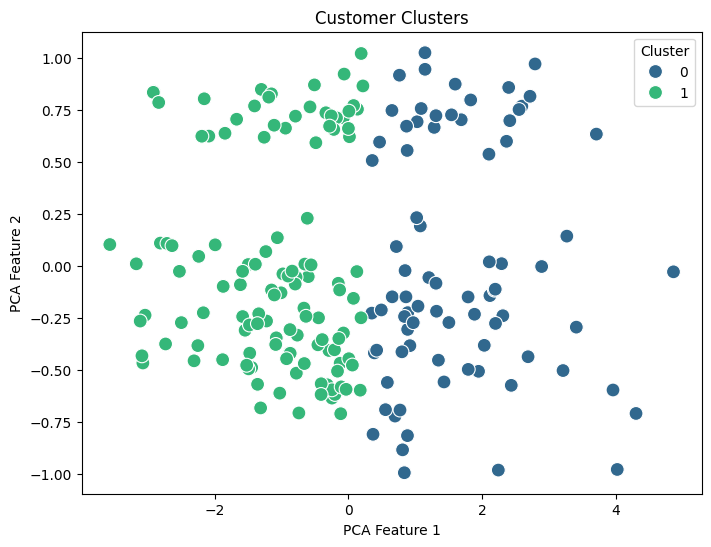

In [31]:
from sklearn.decomposition import PCA

# Reduce features to 2D using PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(clustering_features)

# Plot clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=lookalike_data['Cluster'], palette='viridis', s=100)
plt.title("Customer Clusters")
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.legend(title="Cluster")
plt.show()


In [32]:
# Final DBI score
final_dbi = davies_bouldin_score(clustering_features, lookalike_data['Cluster'])
print("Final Davies-Bouldin Index:", final_dbi)

# Analyze clusters
cluster_summary = lookalike_data.groupby('Cluster').agg({
    'TotalSpending': 'mean',
    'TotalQuantity': 'mean',
    'TransactionCount': 'mean'
}).reset_index()
print("Cluster Summary:\n", cluster_summary)


Final Davies-Bouldin Index: 0.9329250968402458
Cluster Summary:
    Cluster  TotalSpending  TotalQuantity  TransactionCount
0        0       0.927143       0.975846          0.954001
1        1      -0.605325      -0.637123         -0.622860


In [33]:
# Save clustering results to a CSV
lookalike_data.to_csv('Nishu_Rajput_Clustering.csv', index=False)
